# Классификация дорожных знаков

В данной работе рассмотрим задачу классификацию знаков дорожного движения с помощью Резнета и сверточных сетей

### Загрузка данных

In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c aimasters-ml3-contest01-road-signs

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
 99%|███████████████████████████████████████▋| 138M/139M [00:09<00:00, 16.3MB/s]
100%|████████████████████████████████████████| 139M/139M [00:09<00:00, 15.9MB/s]


In [1]:
! unzip ai_m/aimasters-ml3-contest01-road-signs.zip

Archive:  ai_m/aimasters-ml3-contest01-road-signs.zip
replace numbers_to_classes.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [11]:
import os
from tqdm import tqdm
import cv2

In [1]:
filenames = []
labels = []

with open("train.csv", "rt") as fp:
    fp.readline()
    for line in fp:
        fn, label = line.strip().split(",")
        filenames.append("train/" + fn)
        labels.append(int(label))

### Сборка датасетов

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T

import albumentations as A

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models as M
from vit_pytorch import SimpleViT

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
class SignsDataset(Dataset):
    def __init__(self, filenames, labels, split, transforms, augmentations=None):
        self.filenames = filenames
        self.labels = labels
        self.split = split
        self.transforms = transforms
        self.augmentations = augmentations

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, i):
        image = cv2.imread(self.filenames[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

        if self.augmentations is not None:
            image = self.augmentations(image=image)["image"]
        image_tensor = self.transforms(image)

        label = self.labels[i]

        return image_tensor, label

    @staticmethod
    def collate_fn(items):
        images_batch = torch.zeros(len(items), 3, 48, 48)
        labels_batch = torch.zeros(len(items))
        for i, item in enumerate(items):
            images_batch[i] = item[0]
            labels_batch[i] = item[1]
        return images_batch.float(), labels_batch.long()

In [12]:
trans_new = A.Compose(
    [
        A.RandomBrightnessContrast(),
        A.RandomFog(),
        A.RandomRain(),
        A.RandomShadow(),
        A.AdvancedBlur(),
        A.ColorJitter(),
        A.Downscale(),
        A.PixelDropout(),
        A.RandomGamma(),
        A.Sharpen(),
        A.MotionBlur(),
        A.ChannelDropout(),
        A.Emboss(),
        A.Solarize(),
        A.Rotate(limit=10),
    ]
)


trans_s = T.Compose([T.ToTensor()])


dataset = SignsDataset(filenames, labels, "train", trans_s)

means = []
stds = []
for i in tqdm(range(len(dataset))):
    means.append(torch.mean(dataset[i][0], dim=[1, 2]).numpy())
    stds.append(torch.std(dataset[i][0], dim=[1, 2]).numpy())
means = torch.tensor(means)
stds = torch.tensor(stds)

channel_means = torch.mean(means, dim=0).float()
channel_stds = torch.mean(stds, dim=0).float()

trans_s = T.Compose([T.ToTensor(), T.Normalize(channel_means, channel_stds)])


dataset = SignsDataset(filenames, labels, "train", trans_s)

filenames_train, filenames_val, labels_train, labels_val = train_test_split(
    filenames, labels, train_size=0.8, stratify=labels
)

dataset_train = SignsDataset(
    filenames_train, labels_train, "train", trans_s, augmentations=trans_new
)
dataset_val = SignsDataset(filenames_val, labels_val, "val", trans_s)

100%|██████████| 25432/25432 [00:13<00:00, 1835.86it/s]
/tmp/ipykernel_899027/4278855229.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  means = torch.tensor(means)


In [13]:
def tensor_to_image(tensor):
    tensor_denormed = tensor * channel_stds.reshape(3, 1, 1) + channel_means.reshape(
        3, 1, 1
    )  # 3, 48, 48
    image = tensor_denormed.permute(1, 2, 0).numpy()
    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

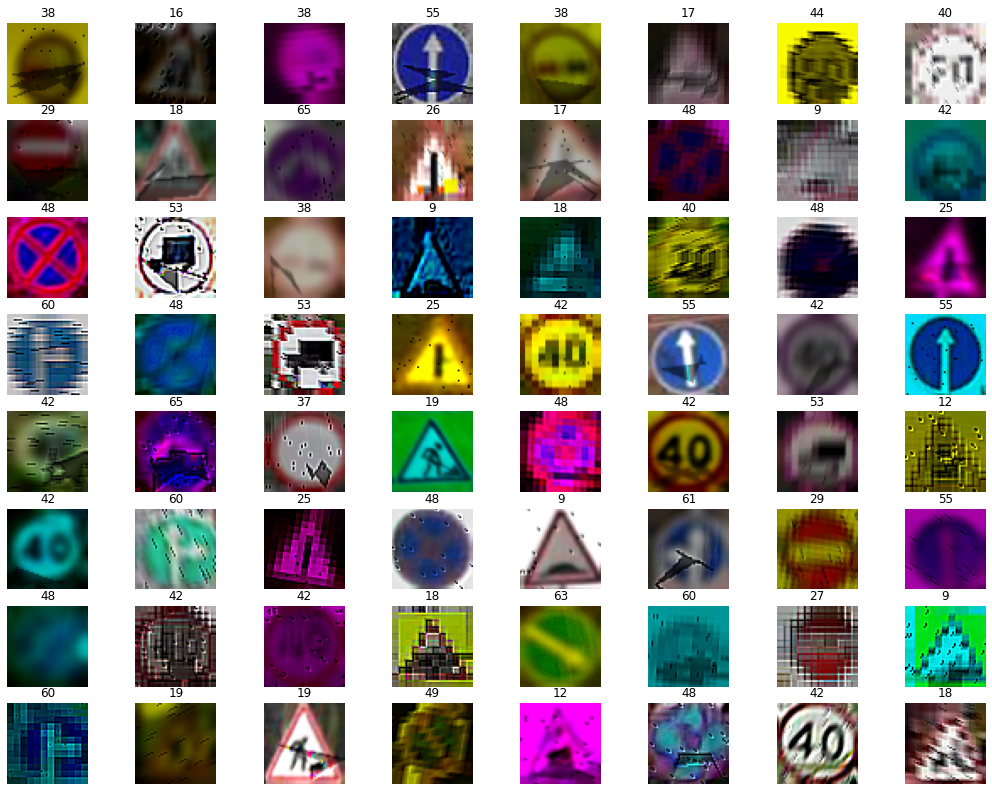

In [84]:
indexes_to_show = np.random.choice(len(dataset_train), size=64, replace=False)

plt.figure(figsize=(18, 14))
for i, index in enumerate(indexes_to_show):
    tensor, label = dataset_train[index]
    image = tensor_to_image(tensor)
    plt.subplot(8, 8, i + 1)
    plt.imshow(image)
    plt.title(label)
    plt.axis(False)
plt.show()

In [85]:
num_labels = np.unique(dataset_train.labels, return_counts=True)[1]
class_weights = torch.from_numpy(1 - num_labels / num_labels.sum())
classes = np.unique(dataset_train.labels, return_counts=True)[0]

### Построение модели

Наилучшим образом показала себя модель Резнета, которая благодаря Skip-connections прокидывала сигнал и фактически имитировала ансамбль моделей. В данной работе изначально использовались ResNet18 и ResNet50, но они недостаточно хорошо справлялись, в связи с чем я принял решение самостоятельно имплементировать ResNet и добавить в него слой, в котором 2048 каналов.

Также в начале в качестве бейзлайна была использована обычная сверточная сеть без residual connections из нескольких сверточных блоков, но она показала себя хуже, что вполне логична, и к сожалению в связи с работой коллаба не сохранилась. Что было далее пофикшено чекпоинтингом на резнете.

In [6]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, pool=True, stride=None):
        super(CNNBlock, self).__init__()
        if stride is not None:
            self.conv1 = nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=(3, 3),
                padding=(1, 1),
                stride=stride,
                bias=False,
            )
        else:
            self.conv1 = nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=(3, 3),
                padding=(1, 1),
                bias=False,
            )
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1), bias=False
        )

        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d((2, 2)) if pool else nn.Identity()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        return x


class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(
                in_channels, out_channels, kernel_size=3, stride=2, padding=1
            )
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels),
            )
        else:
            self.conv1 = nn.Conv2d(
                in_channels, out_channels, kernel_size=3, stride=1, padding=1
            )
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU(True)(self.bn1(self.conv1(input)))
        input = nn.ReLU(True)(self.bn2(self.conv2(input)))
        input = input + shortcut
        return nn.ReLU()(input)

In [7]:
"""
cnn = nn.Sequential(
    CNNBlock(3, 64, stride=2),
    CNNBlock(64, 128),
    CNNBlock(128, 512),
    CNNBlock(256, 512),
    CNNBlock(512, 2048),

    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(2048, 67)
)
"""


class ResNet18(nn.Module):
    def __init__(self, in_channels, resblock, outputs=67):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.layer1 = nn.Sequential(
            resblock(64, 64, downsample=False), resblock(64, 64, downsample=True)
        )

        self.layer2 = nn.Sequential(
            resblock(64, 128, downsample=True), resblock(128, 128, downsample=False)
        )

        self.layer3 = nn.Sequential(
            resblock(128, 256, downsample=True), resblock(256, 256, downsample=False)
        )

        self.layer4 = nn.Sequential(
            resblock(256, 512, downsample=True), resblock(512, 512, downsample=False)
        )

        self.layer5 = nn.Sequential(
            resblock(512, 1024, downsample=True), resblock(1024, 1024, downsample=False)
        )

        self.layer6 = nn.Sequential(
            resblock(1024, 2048, downsample=True),
            resblock(2048, 2048, downsample=False),
        )

        self.gap = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.fc = torch.nn.Linear(2048, outputs)
        self.flat = nn.Flatten()

    def forward(self, input):
        input = self.layer0(input)
        input = self.layer1(input)
        input = self.layer2(input)
        input = self.layer3(input)
        input = self.layer4(input)
        input = self.layer5(input)
        input = self.layer6(input)
        input = self.gap(input)
        input = self.flat(input)
        input = self.fc(input)

        return input

In [8]:
x = torch.randn(4, 3, 48, 48)
resnet = ResNet18(3, ResBlock)
y = cnn_finetuned(x)
y.shape

torch.Size([4, 67])

##### Обучение

In [9]:
num_epochs = 150
batch_size = 64
lr = 3e-4

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [16]:
dataloader_train = DataLoader(
    dataset_train,
    collate_fn=SignsDataset.collate_fn,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=2,
    pin_memory=True,
)

dataloader_val = DataLoader(
    dataset_val,
    collate_fn=SignsDataset.collate_fn,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=2,
    pin_memory=True,
)

Для улучшения показателей модели добавим сглаживание классов, использованное в статье https://arxiv.org/pdf/1906.02629.pdf.

А также будем использовать шедулер, который будет обновляться после того, как наш лосс не растет более 5 эпох

In [17]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1, weight=None):
        """if smoothing == 0, it's one-hot method
        if 0 < smoothing < 1, it's smooth method
        """
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.weight = weight
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        assert 0 <= self.smoothing < 1
        pred = pred.log_softmax(dim=self.dim)

        if self.weight is not None:
            pred = pred * self.weight.unsqueeze(0)

        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [ ]:
class_weights = class_weights.float().to(device)
# classes = torch.from_numpy(classes).to(device)
loss_fn = LabelSmoothingLoss(classes=67, smoothing=0.1, weights=class_weights)
optimizer = torch.optim.Adam(resnet.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=4, verbose=True, min_lr=3e-5
)

In [19]:
def run_epoch(stage, model, dataloader, loss_fn, optimizer, epoch, device):
    if stage == "train":
        model.train()
        torch.set_grad_enabled(True)
    else:
        torch.set_grad_enabled(False)
        model.eval()

    model = model.to(device)

    losses = []
    for batch in tqdm(
        dataloader,
        total=len(dataloader),
        desc=f"epoch: {str(epoch).zfill(3)} | {stage:5}",
    ):
        xs, ys_true = batch

        ys_pred = model(xs.to(device))
        loss = loss_fn(ys_pred, ys_true.to(device))

        if stage == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        losses.append(loss.detach().cpu().item())

    if stage == "train":
        scheduler.step(np.mean(losses))

    return np.mean(losses)

Будем контролировать значение целевой метрики, и сохранять чекпоинт модели в случае, если он лучший.

In [20]:
def save_checkpoint(model, filename):
    with open(filename, "wb") as fp:
        torch.save(model.state_dict(), fp)


def load_checkpoint(model, filename):
    with open(filename, "rb") as fp:
        state_dict = torch.load(fp, map_location="cpu")

    model.load_state_dict(state_dict)

In [21]:
def run_experiment(
    model,
    dataloader_train,
    dataloader_val,
    loss_fn,
    optimizer,
    num_epochs,
    device,
    output_dir,
):
    train_losses = []
    val_losses = []

    best_val_loss = np.inf
    best_val_loss_epoch = -1
    best_val_loss_fn = None

    os.makedirs(output_dir, exist_ok=True)

    for epoch in range(num_epochs):
        train_loss = run_epoch(
            "train", model, dataloader_train, loss_fn, optimizer, epoch, device
        )
        train_losses.append(train_loss)

        val_loss = run_epoch(
            "val", model, dataloader_val, loss_fn, optimizer, epoch, device
        )
        val_losses.append(val_loss)

        print(
            f"epoch: {str(epoch).zfill(3)} | train_loss: {train_loss:5.3f}, val_loss: {val_loss:5.3f} (best: {best_val_loss:5.3f})"
        )

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_loss_epoch = epoch

            output_fn = os.path.join(
                output_dir,
                f"epoch={str(epoch).zfill(2)}_valloss={best_val_loss:.3f}.pth.tar",
            )
            save_checkpoint(model, output_fn)
            print(f"New checkpoint saved to {output_fn}")

            best_val_loss_fn = output_fn

        print()

    print(f"Best val_loss = {best_val_loss:.3f} reached at epoch {best_val_loss_epoch}")
    load_checkpoint(model, best_val_loss_fn)

    return train_losses, val_losses, best_val_loss, model

Запустим:

In [134]:
(
    train_losses_baseline,
    val_losses_baseline,
    best_val_loss_baseline,
    cnn_baseline,
) = run_experiment(
    resnet,
    dataloader_train,
    dataloader_val,
    loss_fn,
    optimizer,
    num_epochs,
    device,
    "resnet18_01smooth",
)

epoch: 000 | train:   7%|▋         | 23/317 [00:02<00:27, 10.64it/s]

Смотрим результаты уже дообученной ранее модели (ох уж этот коллаб):

In [23]:
load_checkpoint(resnet, "resnet18_01smooth/epoch=130_valloss=0.761.pth.tar")

In [181]:
def plot_losses(train_losses, val_losses, title):
    plt.figure(figsize=(12, 5))
    plt.title(title)
    plt.plot(train_losses, label="train")
    plt.plot(val_losses, label="val")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid(True)
    plt.legend()
    plt.show()

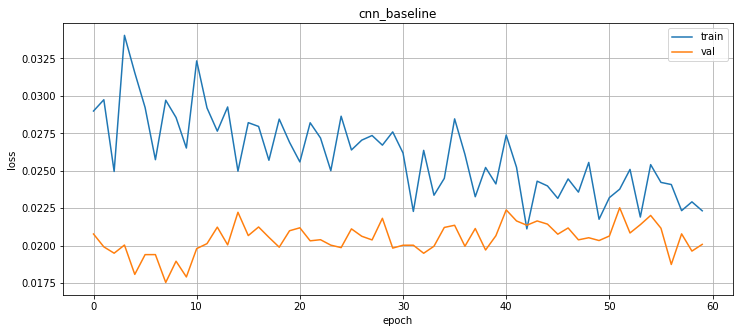

In [182]:
plot_losses(train_losses_baseline, val_losses_baseline, title="cnn_baseline")

Считаем метрики:

In [24]:
def collect_predictions(model, dataloader, device):
    model.eval()
    model = model.to(device)
    torch.set_grad_enabled(False)

    labels_all = []
    probs_all = []
    preds_all = []
    for batch in tqdm(dataloader, total=len(dataloader)):
        images, labels = batch

        logits = model(images.to(device)).cpu()
        probs = logits.softmax(dim=1)
        max_prob, max_prob_index = torch.max(probs, dim=1)

        labels_all.extend(labels.numpy().tolist())
        probs_all.extend(max_prob.numpy().tolist())
        preds_all.extend(max_prob_index.numpy().tolist())

    return labels_all, probs_all, preds_all

In [25]:
train_labels, train_probs, train_preds = collect_predictions(
    resnet, dataloader_train, device
)

accuracy_train = accuracy_score(train_labels, train_preds)
accuracy_train

100%|██████████| 317/317 [00:33<00:00,  9.58it/s]


0.9875788643533123

In [26]:
val_labels, val_probs, val_preds = collect_predictions(resnet, dataloader_val, device)

accuracy_val = accuracy_score(val_labels, val_preds)
accuracy_val

100%|██████████| 80/80 [00:01<00:00, 47.08it/s]


0.9996068409671712

Рассмотрим обьекты на которых наша модель ошибалась

In [68]:
idx = np.array(val_labels) != np.array(val_preds)

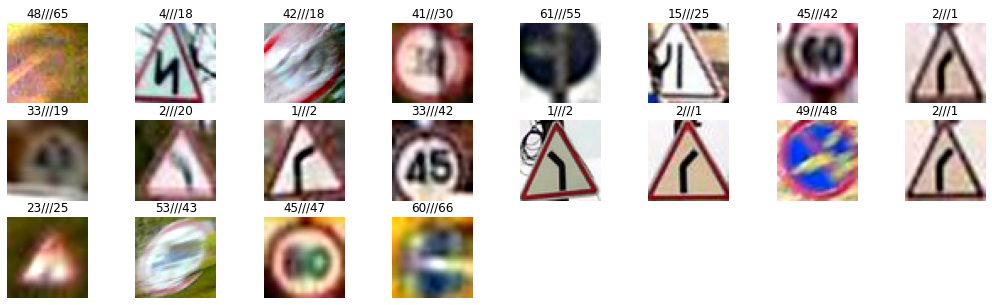

In [69]:
indexes_to_show = idx.nonzero()[0]

plt.figure(figsize=(18, 14))
for i, index in enumerate(indexes_to_show):
    pred_l = np.array(val_preds)[index]
    tensor, label = dataset_val[index]
    image = tensor_to_image(tensor)
    plt.subplot(8, 8, i + 1)
    plt.imshow(image)
    plt.title(str(label) + "///" + str(pred_l))
    plt.axis(False)
plt.show()

Видно, что некоторые знаки почти невозможно определить, некоторые обьекты плохо определяются. Но также заметим, что знак с палочкой налево и направо определяется несколько раз неправильно, а точнее наоборот - правая определяется как будто левой и наоборот. Это в данном случае не ошибка модели, а ошибка в разметке. Рассмотрев несколько таких сэмплов из тренировочной выборки увидим, что на самом деле модель все правильно определяла.